In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Load data from SQLite database
conn = sqlite3.connect('../Housing.sqlite')
query = "SELECT * FROM data"  # Replace 'data' with your table name
merged_df = pd.read_sql_query(query, conn)
conn.close()

In [3]:
# Convert 'Date' column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%y-%b')

In [4]:
# Set 'Date' column as the index
# Remove non-numeric characters from columns
columns_to_clean = ['Median Sale Price', 'Homes Sold', 'New Listings', 'Inventory', 'Days on Market', 'Average Sale To List']
merged_df[columns_to_clean] = merged_df[columns_to_clean].replace('[\$,K,%]', '', regex=True).astype(float)
merged_df.set_index('Date', inplace=True)
merged_df.tail()

,index,Median Sale Price,Homes Sold,New Listings,Inventory,Days on Market,Average Sale To List
Date,,,,,,,
2023-03-01,134,427.0,27003.0,31265.0,68472.0,51.0,97.3
2023-04-01,135,430.0,24794.0,28027.0,65487.0,44.0,97.4
2023-05-01,136,434.0,27907.0,29752.0,64561.0,41.0,97.5
2023-06-01,137,438.0,27369.0,29430.0,64991.0,39.0,97.6
2023-07-01,138,432.0,23086.0,27227.0,64032.0,38.0,97.7


In [5]:
# Set up the training data
train_size = int(len(merged_df) * 0.8)  # 80% for training
train_data, test_data = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

In [6]:
# Extract target variable (y) and features (X) for training
X_train = np.arange(len(train_data)).reshape(-1, 1)
y_train = train_data['Homes Sold']

In [7]:
# Build the SARIMA model
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

c:\Users\Jesse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Jesse\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [8]:
# Forecast into the future
forecast_steps = 60  # Number of steps to forecast
X_future = np.arange(len(X_train), len(X_train) + forecast_steps).reshape(-1, 1)
forecast = sarima_fit.get_forecast(steps=forecast_steps)

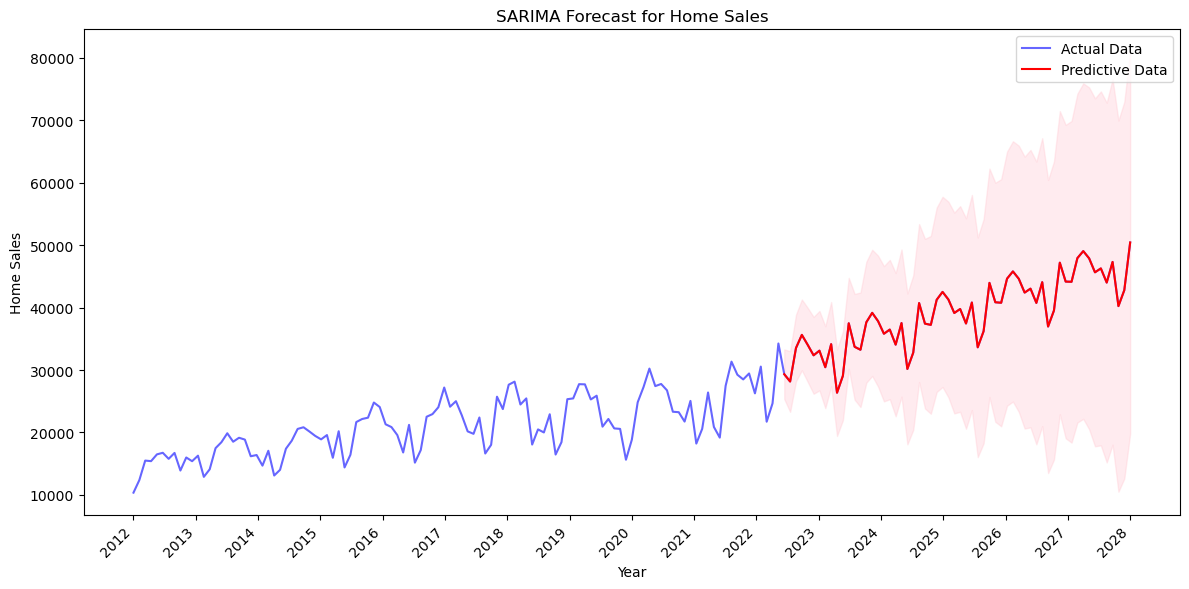

In [9]:
# Plotting
plt.figure(figsize=(12, 6))

# Calculate the number of forecast steps
forecast_steps = len(X_future)
X_predictive = np.arange(X_train[-1] + 1, X_train[-1] + forecast_steps + 1).reshape(-1, 1)

# Set the range for plotting both actual and predictive data
X_combined = np.concatenate((X_train, X_predictive))
y_combined = np.concatenate((y_train, forecast.predicted_mean))

# Plot the combined data
plt.plot(X_combined, y_combined, color='blue', alpha=0.6, label='Actual Data')

# Plot the predictive data
plt.plot(X_predictive, forecast.predicted_mean, color='red', label='Predictive Data')
plt.fill_between(X_predictive.ravel(), forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)

# Set x-axis ticks and labels for both original data and forecast
years_actual = np.arange(merged_df.index.year.min(), merged_df.index.year.max() + 1)
years_forecast = np.arange(merged_df.index.year.max() + 1, merged_df.index.year.max() + forecast_steps // 12 + 1)
years_combined = np.concatenate((years_actual, years_forecast))

# Adjust the position of x-axis ticks for readability
ticks = np.linspace(0, len(X_combined) - 1, len(years_combined))
plt.xticks(ticks, years_combined, rotation=45, ha='right')

plt.title('SARIMA Forecast for Home Sales')
plt.xlabel('Year')
plt.ylabel('Home Sales')
plt.legend()

plt.tight_layout()
output_folder = "../charts"
output_filename = "Home_Sales.png"
output_path = f"{output_folder}/{output_filename}"
plt.savefig(output_path)
plt.show()